In [16]:
%matplotlib inline
import os
import torch
import torchvision
from d2l import torch as d2l

In [17]:
#@save
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

In [18]:
#@save
def read_voc_images(voc_dir, is_train=True):
    """Read all VOC feature and label images."""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode))
    return features, labels

train_features, train_labels = read_voc_images(voc_dir, True)

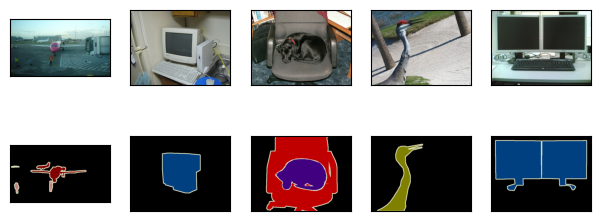

In [19]:
n = 5
imgs = train_features[:n] + train_labels[:n]
imgs = [img.permute(1,2,0) for img in imgs]
d2l.show_images(imgs, 2, n);

In [20]:
#@save
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

#@save
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [21]:
#@save
def voc_colormap2label():
    """Build the mapping from RGB to class indices for VOC labels."""
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

#@save
def voc_label_indices(colormap, colormap2label):
    """Map any RGB values in VOC labels to their class indices."""
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

In [22]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

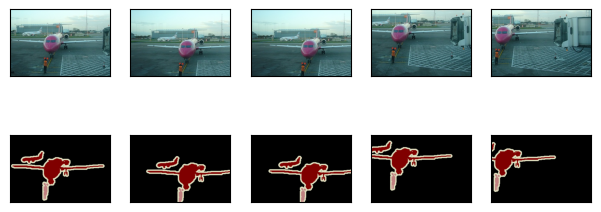

In [23]:
#@save
def voc_rand_crop(feature, label, height, width):
    """Randomly crop both feature and label images."""
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, (height, width))
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)

imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

In [24]:
#@save
class VOCSegDataset(torch.utils.data.Dataset):
    """A customized dataset to load the VOC dataset."""

    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return self.transform(img.float() / 255)

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

In [25]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


In [26]:
batch_size = 64
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True,
                                    drop_last=True,
                                    num_workers=d2l.get_dataloader_workers())
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

torch.Size([64, 3, 320, 480])
torch.Size([64, 320, 480])


In [27]:
#@save
def load_data_voc(batch_size, crop_size):
    """Load the VOC semantic segmentation dataset."""
    voc_dir = d2l.download_extract('voc2012', os.path.join(
        'VOCdevkit', 'VOC2012'))
    num_workers = d2l.get_dataloader_workers()
    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, drop_last=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        drop_last=True, num_workers=num_workers)
    return train_iter, test_iter

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        # Contracting Path
        self.enc_conv1 = self.contract_block(in_channels, 64, 3, 1)
        self.enc_conv2 = self.contract_block(64, 128, 3, 1)
        self.enc_conv3 = self.contract_block(128, 256, 3, 1)
        self.enc_conv4 = self.contract_block(256, 512, 3, 1)
        self.bottleneck = self.contract_block(512, 1024, 3, 1)
        # Expanding Path
        self.dec_conv4 = self.expand_block(1024, 512, 3, 1)
        self.dec_conv3 = self.expand_block(512, 256, 3, 1)
        self.dec_conv2 = self.expand_block(256, 128, 3, 1)
        self.dec_conv1 = self.expand_block(128, 64, 3, 1)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def __call__(self, x):
        # Contracting Path
        e1 = self.enc_conv1(x)
        e2 = self.enc_conv2(e1)
        e3 = self.enc_conv3(e2)
        e4 = self.enc_conv4(e3)
        b = self.bottleneck(e4)
        # Expanding Path
        d4 = self.dec_conv4(b)
        d3 = self.dec_conv3(d4 + e4)
        d2 = self.dec_conv2(d3 + e3)
        d1 = self.dec_conv1(d2 + e2)
        out = self.final_conv(d1 + e1)
        return out

    def contract_block(self, in_channels, out_channels, kernel_size, padding):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        return block

    def expand_block(self, in_channels, out_channels, kernel_size, padding):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
            nn.ReLU(),
            nn.ConvTranspose2d(out_channels, out_channels, kernel_size=2, stride=2)
        )
        return block


In [29]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets

class VOCDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.voc_data = datasets.VOCSegmentation(root_dir, year='2012', image_set='train', download=True)

    def __len__(self):
        return len(self.voc_data)

    def __getitem__(self, idx):
        img, target = self.voc_data[idx]
        if self.transform:
            img = self.transform(img)
        return img, target


In [30]:
from torchvision.transforms import Compose, ToTensor, Resize

class VOCDataset(Dataset):
    def __init__(self, root_dir, image_set='train', download=True, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform or transform  # Use the same transform if target_transform is not specified
        self.voc_data = datasets.VOCSegmentation(root_dir, year='2012', image_set=image_set, download=download)

    def __len__(self):
        return len(self.voc_data)

    def __getitem__(self, idx):
        img, target = self.voc_data[idx]
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            target = self.target_transform(target)
        return img, target

# Setup transformations
transform = Compose([
    Resize((256, 256)),  # Resize both images and masks to 256x256
    ToTensor()
])
target_transform = Compose([
    Resize((256, 256)),  # Ensure target is resized similarly, possibly with nearest interpolation to avoid altering labels
    ToTensor()
])

dataset = VOCDataset(root_dir='path_to_VOC_dataset', transform=transform, target_transform=target_transform)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)


Using downloaded and verified file: path_to_VOC_dataset/VOCtrainval_11-May-2012.tar
Extracting path_to_VOC_dataset/VOCtrainval_11-May-2012.tar to path_to_VOC_dataset
